(quickstart)=
# Quickstart: simple linear regression

We demonstrate here how to use BayesBay to tackle a simple linear regression problem: polynomial fitting. In the following, we utilise a third-degree polynomial, $y(x) = m_0 + m_1 x + m_2 x^2 + m_3 x^3$, to generate data points. Noise is then added to this data. Our objective is to retrieve the coefficients $m_0$, $m_1$, $m_2$, and $m_3$ from the observations.

For simplicity, we shall assume that the data noise is known (refer to this [tutorial](1_hierarchical) for a hierarchical example where the data noise is treated as unknown). We also assume that prior information about the bounds of the true coefficients is available. (Without this information, Bayesian sampling would be inappropriate for tackling this kind of toy problem.)

## Import libraries and define constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesbay as bb

In [2]:
# dimensions and true coefficients
N_DIMS = 4
M0, M1, M2, M3 = 20, -10, -3, 1

# data and noise
N_DATA = 15
DATA_X = np.linspace(-5, 10, N_DATA)
DATA_NOISE_STD = 20

## Synthetic data and data kernel

In matrix notation and without considering noise, our data set can be expressed as

$$\underbrace{\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right)}_{\text{Data}} = \underbrace{\left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)}_{\text{Forward operator or data kernel}} \underbrace{\left(\begin{array}{c}m_0\\m_1\\m_2\\m_3\end{array}\right)}_{\text{Model}},$$

or $\mathbf{d} = \mathbf{G m}$.

The following code block defines the forward operator, which will be utilised throughout the Bayesian sampling and in the generation of noisy data.

In [3]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

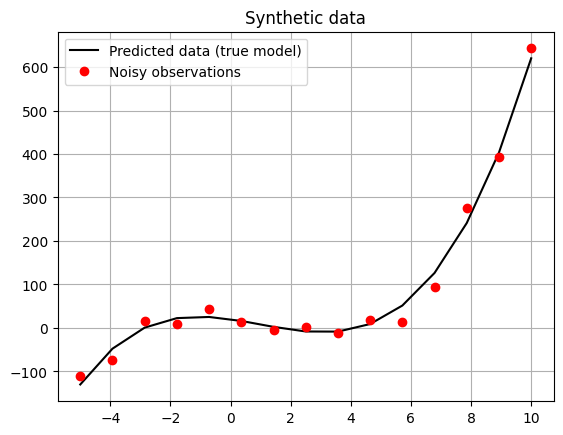

In [4]:
fig, ax = plt.subplots()
ax.set_title('Synthetic data')
ax.plot(DATA_X, y, 'k', label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the coefficients $\mathbf{m}$ from the observations, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknowns parameters and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### Parameterization

As anticipated, we assume that prior information on the bounds of the sought parameters is available. For example, we known that 

* $-100\leq m_0 \leq100$ 
* $-50\leq m_1 \leq50$
* $-20\leq m_2 \leq20$
* $-10\leq m_3 \leq10$. 

This enables us to define uniform probability distributions for each unknown (different options for prior distributions are available through the module [bayesbay.parameters](../api/api_standard_parameters)).

In [4]:
m0 = bb.parameters.UniformParameter("m0", -100, 100, 5)
m1 = bb.parameters.UniformParameter("m1", -50, 50, 5)
m2 = bb.parameters.UniformParameter("m2", -20, 20, 3)
m3 = bb.parameters.UniformParameter("m3", -10, 10, 2)

## define parameterization

In [5]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=4, 
    parameters=[coefficients_param], 
)
parameterization = bb.parameterization.Parameterization(param_space)

## define forward function

In [6]:
def my_fwd(state: bb.State) -> np.ndarray:
    m = state["my_param_space"]["coefficients"]
    return fwd_jacobian @ m
fwd_functions = [my_fwd]

## define data target

In [7]:
targets = [bb.Target("my_data", y_noisy, 1/DATA_NOISE_STD**2)]

## run the sampling

In [8]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=targets, 
    fwd_functions=fwd_functions, 
    n_chains=3, 
    n_cpus=3, 
)
inversion.run(
    sampler=None, 
    n_iterations=100_000, 
    burnin_iterations=10_000, 
    save_every=500, 
    verbose=False, 
)

## get results and plot

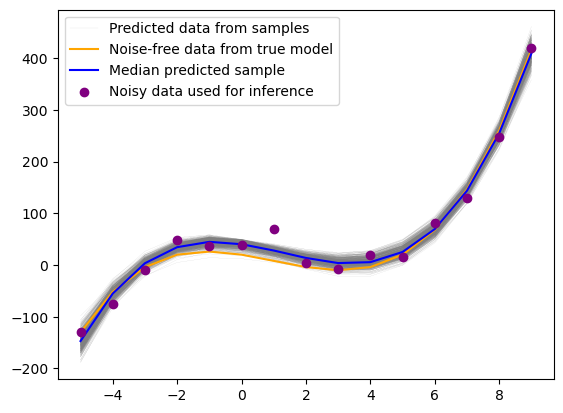

In [9]:
results = inversion.get_results()
coefficients_samples = results["coefficients"]
fig, ax = plt.subplots()
all_y_pred = np.zeros((len(coefficients_samples), len(y)))
for i, coefficients in enumerate(coefficients_samples):
    y_pred = fwd_jacobian @ coefficients
    all_y_pred[i,:] = y_pred
    if i == 0:
        ax.plot(x, y_pred, c="gray", lw=0.05, label="Predicted data from samples")
    else:
        ax.plot(x, y_pred, c="gray", lw=0.05)
ax.plot(x, y, c="orange", label="Noise-free data from true model")
ax.plot(x, np.median(all_y_pred, axis=0), c="blue", label="Median predicted sample")
ax.scatter(x, y_noisy, c="purple", label="Noisy data used for inference", zorder=3)
ax.legend();